# Quanvolutional Neural Networks

In [1]:
import pennylane as qml
# Just like standard NumPy, but with the added benefit of automatic differentiation
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2024-11-20 16:10:50.954433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 16:10:50.954461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 16:10:50.954752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 16:10:51.704679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_epochs = 100
n_layers = 2
n_train = 4000
n_test = 1000
SAVE_PATH = "quanvolution/"
# PREPROCESS = True           # False --> skip quantum processing and load data from SAVE_PATH
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension (for convolution channels)
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [4]:
dev = qml.device("lightning.qubit", wires=4)

# Random circuit parameters
rand_params1 = np.random.uniform(high=2*np.pi, size=(n_layers, 4))
rand_params2 = np.random.uniform(high=2*np.pi, size=(n_layers, 4))
# To convert the function into a QNode running on dev, we apply the qnode() decorator
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params1, wires=list(range(4)))
    RandomLayers(rand_params2, wires=list(range(4)))
    # Measurement (expect. val.) producing 4 classical outputs
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [6]:



# # Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

In [7]:
print("Shape of q_train_images:", q_train_images.shape)
print("Shape of q_test_images:", q_test_images.shape)


Shape of q_train_images: (4000, 14, 14, 4)
Shape of q_test_images: (1000, 14, 14, 4)


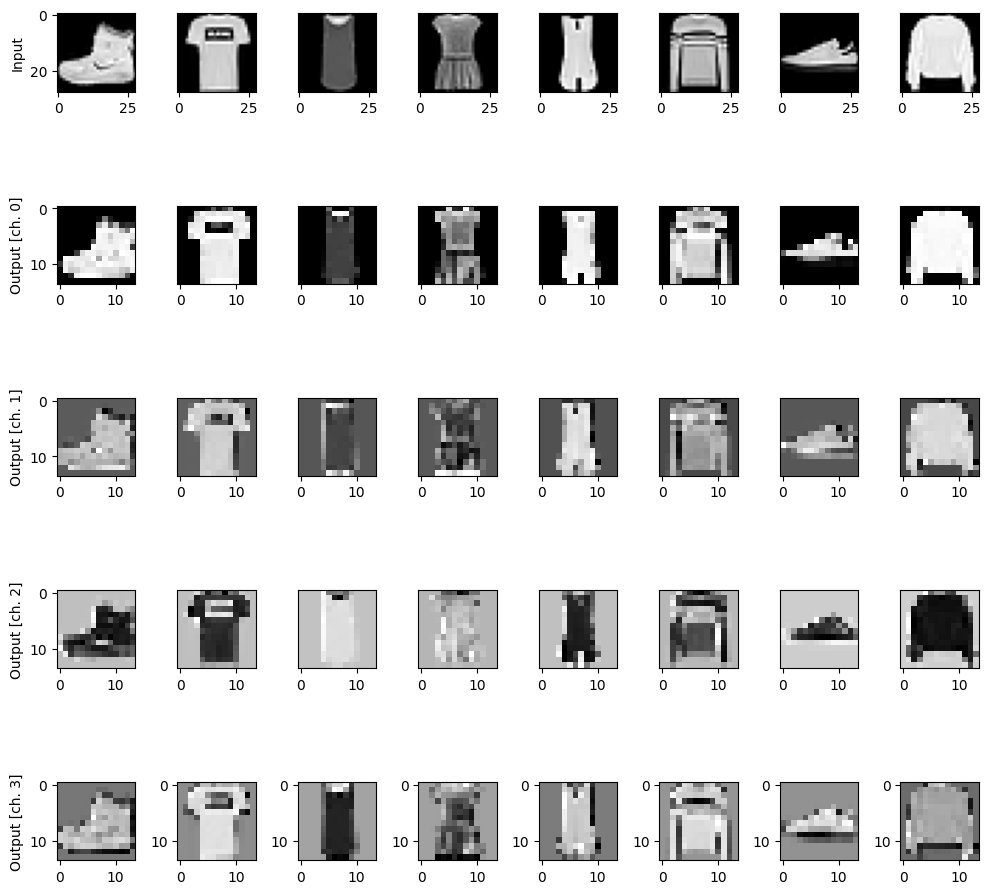

In [8]:
n_samples = 8
n_channels = 4

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples.png', dpi=300, facecolor='w')
plt.show()

In [ ]:
# Define the model architecture
def create_model(input_shape=(14, 14, 4), learning_rate=0.00001):
    """Initializes and returns a Keras model with a custom learning rate"""
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(10, activation="softmax")
    ])

    # Create Adam optimizer with the specified learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,  # Use custom optimizer with learning rate
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Initialize the global model with input shape
global_model = create_model()

# Call the global model on dummy input to initialize weights
dummy_input = np.zeros((1, 14, 14, 4))  # Shape matches quantum-processed images
global_model(dummy_input)

# Simulate a federated learning scenario
client_datasets = []
preferred_ratio = 0.38 # 99% preferred classes, 1% from other classes
num_clients = 6

# Define class preferences for each client to ensure non-IID distribution
class_preferences = {
    0: [0, 1, 2],     # Client 1 prefers classes 0, 1, 2
    1: [3, 4, 5],     # Client 2 prefers classes 3, 4, 5
    2: [6, 7, 8],
    3: [1, 0, 3],
    4: [6, 9, 2],
    5: [4, 5, 9]      # Client 3 prefers classes 6, 7, 8, 9
}

# Flag for IID or non-IID data distribution
iid = False  # Set to True for IID, False for non-IID

X_train_clients = []
y_train_clients = []

if not iid:
    # Non-IID data distribution
    for i in range(num_clients):
        # Get indices of samples that belong to the preferred classes for this client
        class_indices_preferred = np.where(np.isin(train_labels, class_preferences[i]))[0]
        class_indices_others = np.where(~np.isin(train_labels, class_preferences[i]))[0]

        # Determine number of samples for preferred and non-preferred classes
        num_samples = int(len(train_labels) / num_clients)  # Split the data approximately equally
        num_preferred = int(preferred_ratio * num_samples)
        num_others = num_samples - num_preferred

        # Ensure we do not exceed the available number of samples
        num_preferred = min(len(class_indices_preferred), num_preferred)
        num_others = min(len(class_indices_others), num_others)

        # Randomly select samples for preferred and non-preferred classes
        selected_indices_preferred = np.random.choice(class_indices_preferred, num_preferred, replace=False)
        selected_indices_others = np.random.choice(class_indices_others, num_others, replace=False)

        # Combine the selected indices and shuffle them
        selected_indices = np.concatenate([selected_indices_preferred, selected_indices_others])
        np.random.shuffle(selected_indices)

        # Create client dataset
        x_train_client = q_train_images[selected_indices]
        y_train_client = train_labels[selected_indices]

        # Append to client datasets
        X_train_clients.append(x_train_client)
        y_train_clients.append(y_train_client)

        # Print client information
        unique, counts = np.unique(y_train_client, return_counts=True)
        print(f"Client {i + 1} dataset prepared with {len(x_train_client)} samples.")
        print(f"Client {i + 1} class distribution: {dict(zip(unique, counts))}")
else:
    # IID data distribution
    indices = np.arange(len(train_labels))
    np.random.shuffle(indices)

    # Split indices equally among clients
    split_indices = np.array_split(indices, num_clients)

    for i in range(num_clients):
        # Create client dataset
        x_train_client = train_images[split_indices[i]]
        y_train_client = train_labels[split_indices[i]]

        # Append to client datasets
        X_train_clients.append(x_train_client)
        y_train_clients.append(y_train_client)

        # Print client information
        unique, counts = np.unique(y_train_client, return_counts=True)
        print(f"Client {i + 1} dataset prepared with {len(x_train_client)} samples.")
        print(f"Client {i + 1} class distribution: {dict(zip(unique, counts))}")


# Initialize the global model
global_model = create_model()

# Lists to store global metrics
global_train_loss = []
global_train_accuracy = []
global_val_loss = []
global_val_accuracy = []
num_clients = 6
# Federated learning simulation
for round_num in range(100):
    print(f"\n--- Global Round {round_num+1} ---")

    client_weights = []
    client_sample_nums = []
    client_train_loss = []
    client_train_accuracy = []

    for client_num in range(num_clients):
        print(f"\nClient {client_num+1} training...")

        # Create a new local model
        local_model = create_model()

        # Call the local model on dummy input to initialize weights
        local_model(dummy_input)

        # Set local model weights to global model weights
        local_model.set_weights(global_model.get_weights())

        # Train local model
        history = local_model.fit(X_train_clients[client_num], y_train_clients[client_num],
                                  epochs=5, batch_size=64, verbose=0)

        # Record training loss and accuracy
        client_train_loss.append(history.history['loss'][-1])
        client_train_accuracy.append(history.history['accuracy'][-1])

        # Get updated weights
        client_weights.append(local_model.get_weights())
        client_sample_nums.append(len(y_train_clients[client_num]))

    # Aggregate client weights to update global model
    new_weights = []
    total_samples = np.sum(client_sample_nums)
    for weights in zip(*client_weights):
        weighted_avg = np.zeros_like(weights[0])
        for client_weight, sample_num in zip(weights, client_sample_nums):
            weighted_avg += client_weight * (sample_num / total_samples)
        new_weights.append(weighted_avg)

    # Update global model weights
    global_model.set_weights(new_weights)

    # Evaluate global model on training data
    train_loss, train_accuracy = global_model.evaluate(q_train_images, train_labels, verbose=0)
    global_train_loss.append(train_loss)
    global_train_accuracy.append(train_accuracy)

    # Evaluate global model on test data
    val_loss, val_accuracy = global_model.evaluate(q_test_images, test_labels, verbose=0)
    global_val_loss.append(val_loss)
    global_val_accuracy.append(val_accuracy)

    print(f"Round {round_num+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Round {round_num+1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")




Client 1 dataset prepared with 666 samples.
Client 1 class distribution: {0: 74, 1: 87, 2: 92, 3: 69, 4: 52, 5: 54, 6: 64, 7: 50, 8: 53, 9: 71}
Client 2 dataset prepared with 666 samples.
Client 2 class distribution: {0: 45, 1: 78, 2: 72, 3: 80, 4: 86, 5: 87, 6: 49, 7: 63, 8: 49, 9: 57}
Client 3 dataset prepared with 666 samples.
Client 3 class distribution: {0: 50, 1: 79, 2: 69, 3: 56, 4: 49, 5: 54, 6: 89, 7: 96, 8: 68, 9: 56}
Client 4 dataset prepared with 666 samples.
Client 4 class distribution: {0: 81, 1: 95, 2: 63, 3: 77, 4: 60, 5: 57, 6: 56, 7: 60, 8: 64, 9: 53}
Client 5 dataset prepared with 666 samples.
Client 5 class distribution: {0: 51, 1: 61, 2: 87, 3: 62, 4: 57, 5: 63, 6: 81, 7: 61, 8: 58, 9: 85}
Client 6 dataset prepared with 666 samples.
Client 6 class distribution: {0: 61, 1: 54, 2: 60, 3: 65, 4: 80, 5: 77, 6: 55, 7: 63, 8: 55, 9: 96}

--- Global Round 1 ---

Client 1 training...

Client 2 training...

Client 3 training...

Client 4 training...

Client 5 training...

C

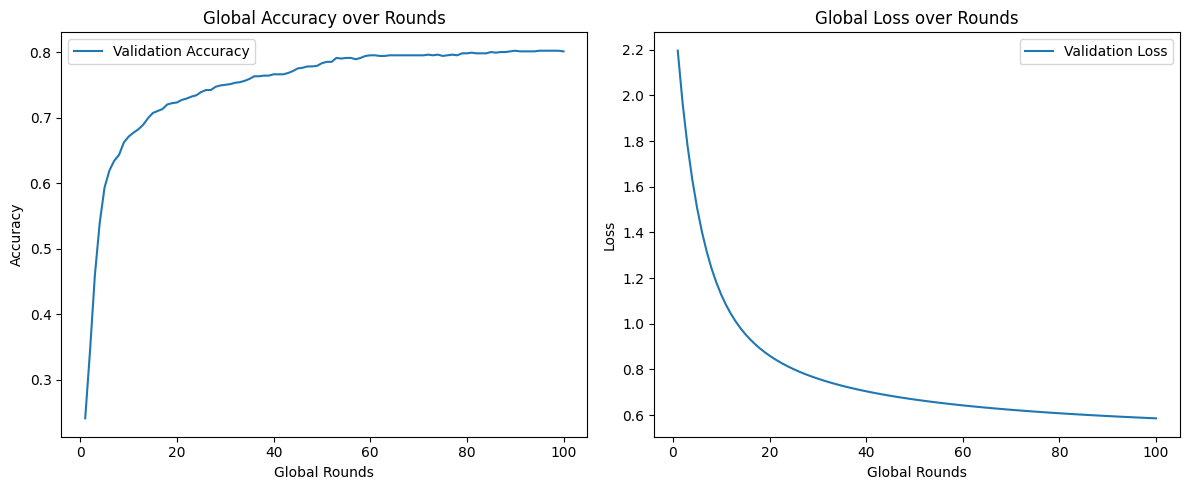

In [19]:
# Plotting the global iteration loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
#lt.plot(range(1, 101), global_train_accuracy, label='Training Accuracy')
plt.plot(range(1, 101), global_val_accuracy, label='Validation Accuracy')
plt.xlabel('Global Rounds')
plt.ylabel('Accuracy')
plt.title('Global Accuracy over Rounds')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(range(1, 101), global_train_loss, label='Training Loss')
plt.plot(range(1, 101), global_val_loss, label='Validation Loss')
plt.xlabel('Global Rounds')
plt.ylabel('Loss')
plt.title('Global Loss over Rounds')
plt.legend()

plt.tight_layout()
plt.show()